In [188]:
from __future__ import division

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from matplotlib import finance

%matplotlib inline

# Loading and Exploring the Data

In [2]:
data = pd.read_csv('WIKI_20160608.csv', names=['Ticker', 'Date', 'Open', 'High', 'Low', 'Close',
                                              'Volume', '7', '8', 'Adj-O', 'Adj-H', 'Adj-L', 'Adj-C',
                                              'Adj-Vol'])

In [3]:
data.head(5)

,Ticker,Date,Open,High,Low,Close,Volume,7,8,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,45.50,50.00,40.00,44.00,44739900.0,0.0,1.0,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,42.94,43.00,39.81,40.38,10897100.0,0.0,1.0,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,41.31,44.00,40.06,44.00,4705200.0,0.0,1.0,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,42.50,43.63,40.25,40.25,4274400.0,0.0,1.0,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,40.13,41.94,40.00,41.06,3464400.0,0.0,1.0,38.440577,40.174379,38.316050,39.331425,3464400.0


Create a new dataframe with only the adjusted data, data, & ticker symbol.

In [4]:
dat = data[['Ticker', 'Date', 'Adj-O', 'Adj-H', 'Adj-L', 'Adj-C', 'Adj-Vol']]

In [5]:
dat.head(5)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,38.440577,40.174379,38.316050,39.331425,3464400.0


In [6]:
dat.shape

(14150093, 7)

Create a dataframe for a specific ticker

In [7]:
agilent = dat[dat['Ticker'] == 'A']

In [8]:
agilent.head()

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol
0,A,1999-11-18,43.584507,47.895063,38.316050,42.147655,44739900.0
1,A,1999-11-19,41.132280,41.189754,38.134049,38.680053,10897100.0
2,A,1999-11-22,39.570901,42.147655,38.373524,42.147655,4705200.0
3,A,1999-11-23,40.710803,41.793232,38.555525,38.555525,4274400.0
4,A,1999-11-24,38.440577,40.174379,38.316050,39.331425,3464400.0


Pretty straight forward to get a ticker specific set of data.  Below I will create a function to automate the process.

In [9]:
def tick_gettr(ticker):
    data = dat[dat['Ticker'] == ticker]
    return data

I will also create an array for all tickers in the dataset in case that comes in handy.

In [10]:
tickers = dat['Ticker']
tickers = tickers.unique()
len(tickers)

3179

Now I will get a ticker specific set of data to work with.

In [11]:
aapl = tick_gettr('AAPL')

## Basic Calculations

I need the components and then the look back period.

Also note that the calculations need to be made for the data historically, not just for the look back period (e.g. look back of 14 days gives us a value just for those 14 days.)  The look back period is how far back the function will look back to make the calculation.

**EXAMPLE:**

Using a lookback period of 14 days will gives us the 14 day calculation for RSI for the entire history of the data set, not just the last 14 days.  I will be able to look & see what the 14 day RSI was for June 25th, 2000 and for the most recent data point as well.

In [12]:
def rs(ticker, look_back):
    """
    A function to find the relative strength of a stock using a user specified
    look back period.
    """
    
    #Get the difference between consecutive adjusted closes.
    difference = ticker['Adj-C'].diff()
    difference = difference[1:]
    
    #Define & clean up the up sessions & down sessions.
    up, down = difference.copy(), difference.copy()
    
    up[up < 0] = 0
    down[down > 0] = 0
    
    #Get the absolute value for the down sessions.
    down = down.abs()
    
    #Get the look_back mean for both up & down sessions.
    upper = up.rolling(window=look_back, center=False).mean()
    downer = down.rolling(window=look_back, center=False).mean()
        
    #Calculate the relative strength
    rs = upper / downer
    
    return rs

In [13]:
def rsi(ticker, look_back):
    """
    A function that determines the relative strength index of a specific stock.
    """
    
    #Get the relative strength.
    r_s = rs(ticker, look_back)
    #Calculate the RSI.
    rsi = 100.0 - 100.0 / (1.0 + r_s)

    return rsi.round(decimals=2)

The Python code to get the RS calculation was greatly informed from this StackOverflow answer:

http://stackoverflow.com/a/29400434/1094634

Also important to note, that some sources will calculate some element of the RSI differently.  Yahoo Finance & ThinkorSwim for instances calculate it the same (and differently from the above calculation) while Freestockcharts.com (Worden) calculates it the same way.

## Buy/Sell Rule:

I will begin with a simple buy/sell rule.  Buy @ the closing price when RSI < 30 & sell @ the closing price when RSI > 70.  The 30 & 70 thresholds are the traditional demarcation points for 'oversold' (<30) & 'overbought' (>70).  These thresholds are ripe for fine tuning.  Initially, I will be using the 14 day average.  The other average that I want to look at is the 9 day.  As with the oversold/overbought level, the optimal average needs to be tested/tuned as well.

Simply, what I want to know is if the RSI predicts higer prices from the buy point.  The actual price itself is not very important (at least in the initial stage.)  If the sell price is consistently higher than buy price, then I will interpret that as the RSI as having some predictive value (whether or not the RSI strategy is more profitable than simply buying the S&P 500 is a separate question.)


First, I will get Apples (AAPL) RSI using the 14 day average.

In [14]:
aapl_rsi = rsi(aapl, 14)

Now I want to add a new column to the dataset to include the RSI

In [15]:
aapl['RSI'] = aapl_rsi

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [16]:
aapl.head(5)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39644,AAPL,1980-12-12,0.436051,0.437871,0.436051,0.436051,117258400.0,NaN
39645,AAPL,1980-12-15,0.415273,0.415273,0.413301,0.413301,43971200.0,NaN
39646,AAPL,1980-12-16,0.384787,0.384787,0.382967,0.382967,26432000.0,NaN
39647,AAPL,1980-12-17,0.392370,0.394342,0.392370,0.392370,21610400.0,NaN
39648,AAPL,1980-12-18,0.403897,0.405717,0.403897,0.403897,18362400.0,NaN


Next I want to remove the first 14 columsn with NaNs for the RSI

In [17]:
aapl = aapl[14:]

In [18]:
aapl.head()

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.50
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.50
39660,AAPL,1981-01-07,0.470177,0.470177,0.468357,0.468357,13921600.0,66.95
39661,AAPL,1981-01-08,0.460622,0.460622,0.458802,0.458802,9956800.0,63.18
39662,AAPL,1981-01-09,0.483524,0.485344,0.483524,0.483524,5376000.0,65.01


Now I want to create some more columns that will show the prices for days where the RSI is < 30 & > 70.

First I will create the Sell column with corresponding prices.

In [19]:
aapl['Sell Price'] = pd.Series(0, np.arange(8935))

In [20]:
aapl.ix[aapl.RSI > 70, 'Sell Price'] = aapl['Adj-C']

Next I will do the same for a Buy column.

In [21]:
aapl['Buy Price'] = pd.Series(0, np.arange(8935))

In [22]:
aapl.ix[aapl.RSI < 30, 'Buy Price'] = aapl['Adj-C']

I will also create several columns that represent holding periods of 1, 3, 5, & 10 days.  I think it will be beneficial to see whether or not arbitrary holding periods show better returns then the RSI > 70 sell point.  These holding periods can be played with and they are picked to represent the shorter term nature of this type of trade.

In [23]:
base = aapl.copy()
base = base['Adj-C']

day_1 = base.shift(-1)
day_3 = base.shift(-3)
day_5 = base.shift(-5)
day_10 = base.shift(-10)

In [24]:
aapl['Day 1'] = day_1
aapl['Day 3'] = day_3
aapl['Day 5'] = day_5
aapl['Day 10'] = day_10

In [25]:
aapl.head(5)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.50,NaN,NaN,0.489136,0.458802,0.479581,0.498539
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.50,NaN,NaN,0.468357,0.483524,0.462594,0.483524
39660,AAPL,1981-01-07,0.470177,0.470177,0.468357,0.468357,13921600.0,66.95,NaN,NaN,0.458802,0.479581,0.464565,0.492928
39661,AAPL,1981-01-08,0.460622,0.460622,0.458802,0.458802,9956800.0,63.18,NaN,NaN,0.483524,0.462594,0.473969,0.498539
39662,AAPL,1981-01-09,0.483524,0.485344,0.483524,0.483524,5376000.0,65.01,NaN,NaN,0.479581,0.464565,0.470177,0.496719


In [26]:
aapl.tail(1)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
48592,AAPL,2016-06-08,99.02,99.56,98.68,98.94,20689762.0,70.54,98.94,NaN,NaN,NaN,NaN,NaN


Now I have a complete dataset to begin working with.

# Analyzing the Data

### A simple and naive regression

First I am going to run a simple regression of the RSI column against the adjusted close column to see what that looks like.

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
aapl_prices = aapl[['Adj-C']]
aapl_rsi_d = aapl[['RSI']]

Splitting the training & test data.  I will do this manually since the historical order of the data is important.  I want to train the model on the older data and test it on the newer data to see if there is any predictive abilities.  A **caveat** here, however, this where many of these types of strategies and analytical approaches end up overfitting and producing models the have *disatsrous* results in the real world.

In [29]:
train_f = aapl_rsi_d[:7148]
train_p = aapl_prices[:7148]
test_f = aapl_rsi_d[7148:]
test_p = aapl_prices[7148:]

In [30]:
simple_linear = LinearRegression()
simple_linear.fit(train_f, train_p)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
predicted_price = simple_linear.predict(test_f)

In [32]:
simple_linear.score(test_f, test_p)

-4.4864101023722318

Not so good

Let's see what the RSS is.

In [33]:
np.sum((predicted_price - test_p) ** 2)

Adj-C    9.356749e+06
dtype: float64

Let's plot this out

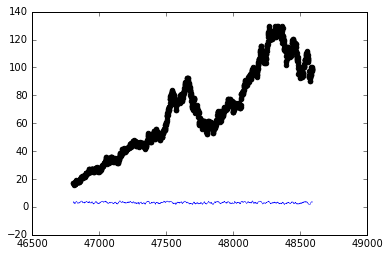

In [34]:
plt.scatter(test_f.index, test_p, color='black')
plt.plot(test_f.index, predicted_price, color='blue', linewidth=.5)

Obviously simply using the RSI values without any type of filter to predict prices is not effective.

Now I will use a number of features to see what the result is.

In [35]:
multi_naive_features = aapl[['Adj-O', 'Adj-H', 'Adj-L', 'Adj-Vol', 'RSI']]

multi_train_f = multi_naive_features[:7148]
multi_test_f = multi_naive_features[7148:]

In [36]:
multi_simple_linear = LinearRegression()
multi_simple_linear.fit(multi_train_f, train_p)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [37]:
multi_predicted_price = multi_simple_linear.predict(multi_test_f)

In [38]:
multi_simple_linear.score(multi_test_f, test_p)

0.99981783502231891

RSS

In [39]:
np.sum((multi_predicted_price - test_p) ** 2)

Adj-C    310.671642
dtype: float64

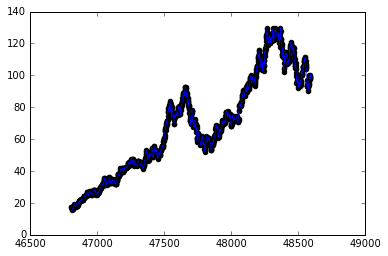

In [40]:
plt.scatter(multi_test_f.index, test_p, color='black')
plt.plot(multi_test_f.index, multi_predicted_price, color='blue', linewidth=.5)

These are some overfit results.  Now it's time to start thinking about how to use the RSI thresholds described above.

First I want to create another column that will show the post buy sell signal.  I want to keep a sell column as well, since it theoretically possible to use the overbought signal as signal to short.  Anecdotally the short signal using RSI hasn't not been considered very successful and any number of theories as to why have been floated, however, I have never tested this and want to keep that option open.

I will create another new column, 'Sell Signal Price', which will hold the closing price when the sell signal is generated.

In [41]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10
39658,AAPL,1981-01-05,0.513706,0.513706,0.511886,0.511886,8932000.0,64.5,NaN,NaN,0.489136,0.458802,0.479581,0.498539
39659,AAPL,1981-01-06,0.490956,0.490956,0.489136,0.489136,11289600.0,64.5,NaN,NaN,0.468357,0.483524,0.462594,0.483524


In [42]:
quick = aapl[['Adj-C', 'RSI', 'Sell Price', 'Buy Price']]

In [43]:
quick['Sell Signal Price'] = pd.Series(0, np.arange(8935))
quick.head()

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Adj-C,RSI,Sell Price,Buy Price,Sell Signal Price
39658,0.511886,64.50,NaN,NaN,NaN
39659,0.489136,64.50,NaN,NaN,NaN
39660,0.468357,66.95,NaN,NaN,NaN
39661,0.458802,63.18,NaN,NaN,NaN
39662,0.483524,65.01,NaN,NaN,NaN


In [44]:
quick = quick.fillna(0)
print quick.iloc[62]
print quick.iloc[9]

Adj-C                 0.399954
RSI                  71.410000
Sell Price            0.399954
Buy Price             0.000000
Sell Signal Price     0.000000
Name: 39720, dtype: float64
Adj-C                 0.470177
RSI                  29.550000
Sell Price            0.000000
Buy Price             0.470177
Sell Signal Price     0.000000
Name: 39667, dtype: float64


Now I will make a for loop to populate this new column with the relevant closing prices.

In [45]:
for price in quick.iterrows():
    if 0 < price[1][1] < 30:
        place = quick.query(price[0])
        p_start = quick.index.get_loc(place.name)
        temp_list = quick[p_start:]
        
        for i in temp_list.iterrows():
            if i[1][1] > 70:
                price[1][4] = i[1][0]
                break

In [46]:
print quick.iloc[9]

Adj-C                 0.470177
RSI                  29.550000
Sell Price            0.000000
Buy Price             0.470177
Sell Signal Price     0.399954
Name: 39667, dtype: float64


Now we have multiple columns with various price data.

In [47]:
quick.head()

,Adj-C,RSI,Sell Price,Buy Price,Sell Signal Price
39658,0.511886,64.50,0.0,0.0,0.0
39659,0.489136,64.50,0.0,0.0,0.0
39660,0.468357,66.95,0.0,0.0,0.0
39661,0.458802,63.18,0.0,0.0,0.0
39662,0.483524,65.01,0.0,0.0,0.0


In [48]:
new_features = quick[['RSI', 'Buy Price']]
new_prices = quick[['Sell Signal Price']]

new_ftrain = new_features[:7148]
new_ptrain = new_prices[:7148]
new_ftest = new_features[7148:]
new_ptest = new_prices[7148:]

In [49]:
rsi_30_model = LinearRegression()
rsi_30_model.fit(new_ftrain, new_ptrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
new_30_predictions = rsi_30_model.predict(new_ftest)

In [51]:
rsi_30_model.score(new_ftest, new_ptest)

0.98512976758219584

In [52]:
np.sum((new_30_predictions - new_ptest) ** 2)

Sell Signal Price    11671.091729
dtype: float64

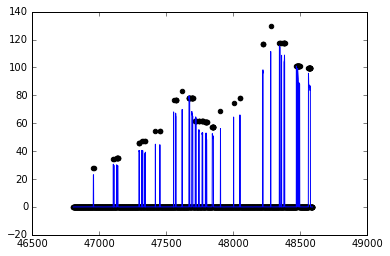

In [53]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, new_30_predictions, color='blue', linewidth=1)

### Using a decision tree regressor

In [54]:
from sklearn.tree import DecisionTreeRegressor

In [55]:
trereg_2 = DecisionTreeRegressor(max_depth=2)
trereg_5 = DecisionTreeRegressor(max_depth=5)

In [56]:
trereg_2.fit(new_ftrain, new_ptrain)
trereg_5.fit(new_ftrain, new_ptrain)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [57]:
tree_2_predict = trereg_2.predict(new_ftest)

In [58]:
tree_5_predict = trereg_5.predict(new_ftest)

In [59]:
trereg_2.score(new_ftest, new_ptest)

0.29166041143263166

In [60]:
trereg_5.score(new_ftest, new_ptest)

0.27080168559486484

In [61]:
rsi_30_actual = new_ptest.as_matrix(columns=['Sell Signal Price'])
rsi_30_actual =  rsi_30_actual.reshape((1787,))

In [62]:
np.sum((tree_2_predict - rsi_30_actual) ** 2)

555949.3679156045

In [63]:
np.sum((tree_5_predict - rsi_30_actual) ** 2)

572320.60514729063

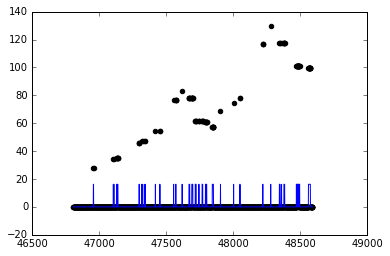

In [64]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, tree_2_predict, color='blue', linewidth=1)

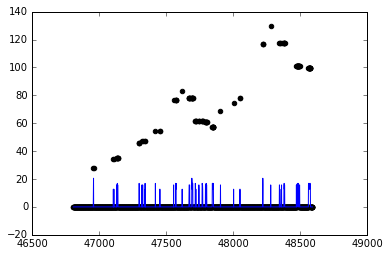

In [65]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, tree_5_predict, color='blue', linewidth=1)

In [66]:
trereg_20 = DecisionTreeRegressor(max_depth=20)
trereg_20.fit(new_ftrain, new_ptrain)
tree_20_predict = trereg_20.predict(new_ftest)

In [67]:
trereg_20.score(new_ftest, new_ptest)

0.31587220712735031

In [68]:
np.sum((tree_20_predict - rsi_30_actual) ** 2)

536946.43100535101

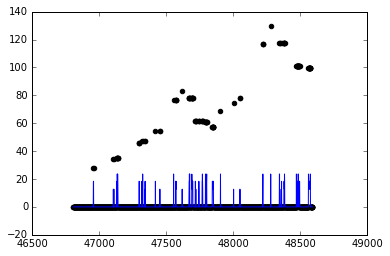

In [69]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, tree_20_predict, color='blue', linewidth=1)

## Using holding periods

In order to avoid training each possibilty by hand, I'll now write a function to automate the process.  This idea is inspired by University of Washingtons Linear Regression course on Coursera.

In [70]:
periods = ['Day 1', 'Day 3', 'Day 5', 'Day 10']
hold_features = ['RSI', 'Buy Price']

quick_1 = aapl[['RSI', 'Buy Price', 'Day 1', 'Day 3', 'Day 5', 'Day 10']]

In [71]:
def predictor(data, periods, features):
    """
    A function to automate the modeling for linear regression.  The data param is the data set
    that the models will be trained on and predictions made from.  The periods param will contain a list of
    the columns that will contain the relevant price data.
    """
    
    #Create and prepare the feature data set.
    features = data[features]
    features = features.fillna(0)
#     features = features.reshape((8935,1))
    train_f = features[:7148]
    test_f = features[7148:]
    
    for i in periods:
        #Create and prepare the price data set.
        prices = data[i]
        prices = prices.fillna(0)
        prices = prices.reshape((8935,1))
        
        train_p = prices[:7148]
        test_p = prices[7148:]
        
        #Train model & make predictions.
        model = LinearRegression()
        model.fit(train_f, train_p)
        predictions = model.predict(test_f)
        
        #Get RSS.
        rss = np.sum((predictions - test_p) ** 2)
        
        #Model score.
        score = model.score(test_f, test_p)
        
        print "The score, {}, and RSS, {}, of the model for {}".format(score, rss, i)
    

In [72]:
predictor(quick_1, periods, hold_features)

The score, -4.05448784097, and RSS, 8630669.29191, of the model for Day 1
The score, -4.04152152132, and RSS, 8629283.47635, of the model for Day 3
The score, -4.03151988386, and RSS, 8632681.31584, of the model for Day 5
The score, -4.00502160549, and RSS, 8636099.24864, of the model for Day 10


As we saw in the older notebooks, using holding periods did not produce very good predicitive results.

I also want to see if the actual "returns" (defined here simply as the sum of the difference between the buy price & sell signal price) were positive.  This is not an actual backtest, but more of a quick look to see whether or not a simple strategy of buy & selling using the RSI 30/70 generated a positive or negative result.

In [73]:
comp_list = []

for line in quick.iterrows():
    if line[1][4] > 0:
        asd = line[1][4] - line[1][3]
        comp_list.append(asd)
        
sum(comp_list)

272.92292481936585

Again, this isn't meant to replace a legitmate backtest, but simply a quick look to see if buying & selling over the public of a security produced a positve result.  When we start to factor in comissions, slippage, risk management, and position size the actual results would be different from the "back of the envelope" calculation.

# Using Different Thresholds & Timeframes

I will begin by using the 9 day moving average mentioned above.  The timeframe of moving averages tend to be arbitrary and rely upon customs that have been used by technical analysts & chartists over the decades.  No doubt as the increased quantification of trading & finance many of these moving averages (m.a.) have come under scrutiny there is still heavy reliance on the traditional metrics (e.g. the 50 & 200 day m.a.)

I will once again use Apple as the test stock.

In [74]:
aapl = tick_gettr('AAPL')

In [75]:
aapl_9_rsi = rsi(aapl, 9)

In [76]:
aapl['RSI'] = aapl_9_rsi

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [77]:
aapl.head(10)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39644,AAPL,1980-12-12,0.436051,0.437871,0.436051,0.436051,117258400.0,NaN
39645,AAPL,1980-12-15,0.415273,0.415273,0.413301,0.413301,43971200.0,NaN
39646,AAPL,1980-12-16,0.384787,0.384787,0.382967,0.382967,26432000.0,NaN
39647,AAPL,1980-12-17,0.392370,0.394342,0.392370,0.392370,21610400.0,NaN
39648,AAPL,1980-12-18,0.403897,0.405717,0.403897,0.403897,18362400.0,NaN
39649,AAPL,1980-12-19,0.428468,0.430440,0.428468,0.428468,12157600.0,NaN
39650,AAPL,1980-12-22,0.449398,0.451218,0.449398,0.449398,9340800.0,NaN
39651,AAPL,1980-12-23,0.468357,0.470177,0.468357,0.468357,11737600.0,NaN
39652,AAPL,1980-12-24,0.492928,0.494899,0.492928,0.492928,12000800.0,NaN
39653,AAPL,1980-12-26,0.538429,0.540249,0.538429,0.538429,13893600.0,74.55


In [78]:
aapl = aapl[9:]

In [79]:
aapl.head(1)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
39653,AAPL,1980-12-26,0.538429,0.540249,0.538429,0.538429,13893600.0,74.55


In [80]:
aapl['Sell Price'] = pd.Series(0, np.arange(8940))
aapl.ix[aapl.RSI > 70, 'Sell Price'] = aapl['Adj-C']

In [81]:
aapl['Buy Price'] = pd.Series(0, np.arange(8940))
aapl.ix[aapl.RSI < 30, 'Buy Price'] = aapl['Adj-C']

In [82]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
39653,AAPL,1980-12-26,0.538429,0.540249,0.538429,0.538429,13893600.0,74.55,0.538429,NaN
39654,AAPL,1980-12-29,0.546012,0.547984,0.546012,0.546012,23290400.0,84.31,0.546012,NaN


In [83]:
base = aapl.copy()
base = base['Adj-C']

day_1 = base.shift(-1)
day_3 = base.shift(-3)
day_5 = base.shift(-5)
day_10 = base.shift(-10)

In [84]:
aapl['Day 1'] = day_1
aapl['Day 3'] = day_3
aapl['Day 5'] = day_5
aapl['Day 10'] = day_10

In [85]:
aapl['Sell Signal Price'] = pd.Series(0, np.arange(8935))

In [86]:
aapl = aapl.fillna(0)

In [87]:
aapl.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Day 1,Day 3,Day 5,Day 10,Sell Signal Price
39653,AAPL,1980-12-26,0.538429,0.540249,0.538429,0.538429,13893600.0,74.55,0.538429,0.0,0.546012,0.517650,0.511886,0.479581,0.0
39654,AAPL,1980-12-29,0.546012,0.547984,0.546012,0.546012,23290400.0,84.31,0.546012,0.0,0.532665,0.523262,0.489136,0.462594,0.0


Now I have cleaned up my data and added some additional data like I did above.  Next I will populate the 'Sell Signal Price' column and then move onto the regression

In [88]:
quick_9 = aapl[['Adj-C', 'RSI', 'Sell Price', 'Buy Price', 'Sell Signal Price']]

In [89]:
quick_9.iloc[13]

Adj-C                 0.473969
RSI                  29.710000
Sell Price            0.000000
Buy Price             0.473969
Sell Signal Price     0.000000
Name: 39666, dtype: float64

In [90]:
for price in quick_9.iterrows():
    if 0 < price[1][1] < 30:
        place = quick_9.query(price[0])
        p_start = quick_9.index.get_loc(place.name)
        temp_list = quick_9[p_start:]
        
        for i in temp_list.iterrows():
            if i[1][1] > 70:
                price[1][4] = i[1][0]
                break

In [91]:
quick_9.iloc[13]

Adj-C                 0.473969
RSI                  29.710000
Sell Price            0.000000
Buy Price             0.473969
Sell Signal Price     0.405717
Name: 39666, dtype: float64

My train/test sets.

In [92]:
new_features = quick_9[['RSI', 'Buy Price']]
new_prices = quick_9[['Sell Signal Price']]

new_ftrain = new_features[:7152]
new_ptrain = new_prices[:7152]
new_ftest = new_features[7152:]
new_ptest = new_prices[7152:]

In [93]:
rsi_9_model = LinearRegression()
rsi_9_model.fit(new_ftrain, new_ptrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [94]:
rsi_9_predictions = rsi_9_model.predict(new_ftest)

In [95]:
rsi_9_model.score(new_ftest, new_ptest)

0.99313047238565977

In [96]:
np.sum((rsi_9_predictions - new_ptest) ** 2)

Sell Signal Price    9260.092403
dtype: float64

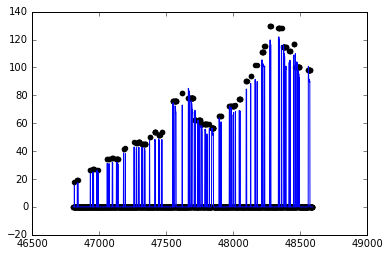

In [97]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, rsi_9_predictions, color='blue', linewidth=1)

It looks as though I am fitting the curve very tightly.  This is somewhat expected actually.  One of the most persistent issues with machine learning and trading is the overfitting problem.  Here we see with more trading events, the model is in fact fitting the data almost perfectly.

Now I will run the decision tree regression.

In [98]:
tree9_2 = DecisionTreeRegressor(max_depth=2)
tree9_5 = DecisionTreeRegressor(max_depth=5)
tree9_20 = DecisionTreeRegressor(max_depth=20)

In [99]:
tree9_2.fit(new_ftrain, new_ptrain)
tree9_5.fit(new_ftrain, new_ptrain)
tree9_20.fit(new_ftrain, new_ptrain)

DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [100]:
tree9_2_predict = tree9_2.predict(new_ftest)
tree9_5_predict = tree9_5.predict(new_ftest)
tree9_20_predict = tree9_20.predict(new_ftest)

In [101]:
print tree9_2.score(new_ftest, new_ptest)
print tree9_5.score(new_ftest, new_ptest)
print tree9_20.score(new_ftest, new_ptest)

0.286652608931
0.286379440629
0.313487783451


In [102]:
rsi_9_actual = new_ptest.as_matrix(columns=['Sell Signal Price'])
rsi_9_actual =  rsi_9_actual.reshape((1788,))

In [103]:
print np.sum((tree9_2_predict - rsi_9_actual) ** 2)
print np.sum((tree9_5_predict - rsi_9_actual) ** 2)
print np.sum((tree9_20_predict - rsi_9_actual) ** 2)

961589.082591
961957.312237
925415.387739


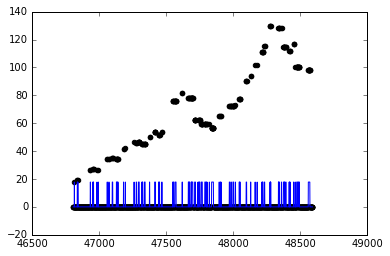

In [104]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, tree9_2_predict, color='blue', linewidth=1)

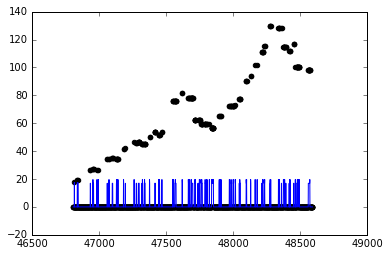

In [105]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, tree9_5_predict, color='blue', linewidth=1)

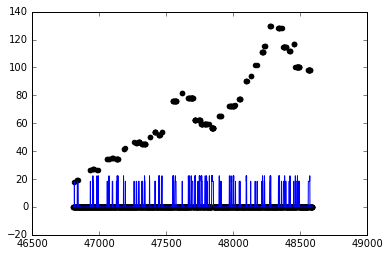

In [106]:
plt.scatter(new_ftest.index, new_ptest, color='black')
plt.plot(new_ftest.index, tree9_20_predict, color='blue', linewidth=1)

As with the decision tree with the 14 day RSI dataset, we see predictions that don't really correlate with the price data.  It seems pretty self evident that the decision tree is being overly impacted by the early data and is running into problems with predicting accurate prices.

I also want to make the same back of the envelope calculation as I did above to see what effect more trades had on this strategy.

In [107]:
comp_list_9 = []

for line in quick_9.iterrows():
    if line[1][4] > 0:
        asd = line[1][4] - line[1][3]
        comp_list_9.append(asd)
        
sum(comp_list_9)

489.68117861896803

In [108]:
print "RSI 14 day # of trades: {}, RSI 9 day # of trades: {}".format(len(comp_list), len(comp_list_9))

RSI 14 day # of trades: 905, RSI 9 day # of trades: 1436


This is an interesting outcome, since typically more trades has a worse performance.  My expectation, even with this simplistic calculation, was that this sum total would be lower.  However, given that we are looking at only 905 & 1436 trades since 1980, this probably does not qualify as overtrading and my assumptions that the performance is worse for the 9 day RSI is probably unfounded.

Finally I want to consider a lower threshold for the buy signal.  I will use 25 as the lower threshold.  I will also do so on both of the 9 & 14 day datasets that I already have.

In [109]:
quick['Sell Signal Price'] = pd.Series(0, np.arange(8935))
quick = quick.fillna(0)

In [110]:
for price in quick.iterrows():
    if 0 < price[1][1] < 25:
        place = quick.query(price[0])
        p_start = quick.index.get_loc(place.name)
        temp_list = quick[p_start:]
        
        for i in temp_list.iterrows():
            if i[1][1] > 70:
                price[1][4] = i[1][0]
                break

In [111]:
quick_9['Sell Signal Price'] = pd.Series(0, np.arange(8940))
quick_9 = quick_9.fillna(0)

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [112]:
for price in quick_9.iterrows():
    if 0 < price[1][1] < 25:
        place = quick_9.query(price[0])
        p_start = quick_9.index.get_loc(place.name)
        temp_list = quick_9[p_start:]
        
        for i in temp_list.iterrows():
            if i[1][1] > 70:
                price[1][4] = i[1][0]
                break

**14 day RSI**

In [113]:
features_25 = quick[['RSI', 'Buy Price']]
prices_25 = quick[['Sell Signal Price']]

ftrain_25 = features_25[:7148]
ptrain_25 = prices_25[:7148]
ftest_25 = features_25[7148:]
ptest_25 = prices_25[7148:]

In [114]:
rsi_1425_model = LinearRegression()
rsi_1425_model.fit(ftrain_25, ptrain_25)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [115]:
predic_1425 = rsi_1425_model.predict(ftest_25)

In [116]:
rsi_1425_model.score(ftest_25, ptest_25)

0.43705556153923253

In [117]:
np.sum((predic_1425 - ptest_25) ** 2)

Sell Signal Price    228745.30925
dtype: float64

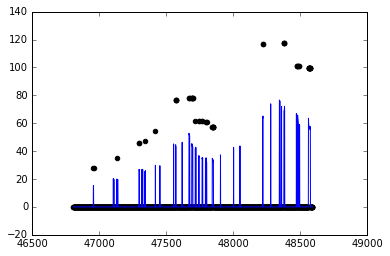

In [118]:
plt.scatter(ftest_25.index, ptest_25, color='black')
plt.plot(ftest_25.index, predic_1425, color='blue', linewidth=1)

The predictions seem to be off quite a bit.  The curve of the predicted prices seems to match the curve of the price data, but the price predictions are off.

Quick back of the envelope calculation.

In [119]:
comp_list25 = []

for line in quick.iterrows():
    if line[1][4] > 0:
        asd = line[1][4] - line[1][3]
        comp_list25.append(asd)
        
sum(comp_list25)

184.51507009511175

In [120]:
len(comp_list25)

498

Here we have an interesting, but somewhat understandable outcome.  We have fewer trades, but they are so few in fact that we are missing out on some opportunities.  The sum total of all the trades is roughly 67% of the 30 RSI buy threshold.  Again, this is not meant to be an accurate backtest, merely a quick check to see if we have greater "returns" given specific parameters.

**9 day RSI**

In [121]:
features_925 = quick_9[['RSI', 'Buy Price']]
prices_925 = quick_9[['Sell Signal Price']]

ftrain_925 = features_925[:7148]
ptrain_925 = prices_925[:7148]
ftest_925 = features_925[7148:]
ptest_925 = prices_925[7148:]

In [122]:
rsi_925_model = LinearRegression()
rsi_925_model.fit(ftrain_925, ptrain_925)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [123]:
predic_925 = rsi_925_model.predict(ftest_925)

In [124]:
rsi_925_model.score(ftest_925, ptest_925)

0.59028378367327505

In [125]:
np.sum((predic_925 - ptest_925) ** 2)

Sell Signal Price    374921.398126
dtype: float64

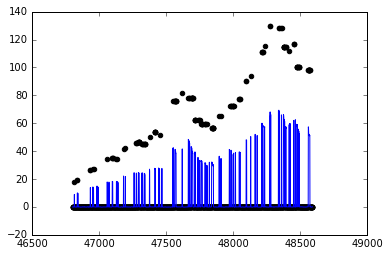

In [126]:
plt.scatter(ftest_925.index, ptest_925, color='black')
plt.plot(ftest_925.index, predic_925, color='blue', linewidth=1)

In [127]:
comp_list925 = []

for line in quick_9.iterrows():
    if line[1][4] > 0:
        asd = line[1][4] - line[1][3]
        comp_list925.append(asd)
        
sum(comp_list925)

338.83749963121716

In [128]:
len(comp_list925)

920

The predictions are off for the RSI 9 day with the 25 buy threshold as well, however, once again we a similar curve to the price data.

I want to try the rsi_9_model on some other stock data.  This model seems to be the most effective.

The first stock is Google.  Google has a shorter history than Apple, but it is also in a related industry.
###### *Note: the GOOG dataset only goes back ~2 years.*

In [129]:
goog = tick_gettr('GOOG')

In [130]:
goog_rsi = rsi(goog, 9)

In [131]:
goog['RSI'] = goog_rsi

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [132]:
goog = goog.iloc[9:]

In [133]:
goog.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI
5625029,GOOG,2014-04-09,559.62,565.37,552.95,564.14,3321700.0,53.78
5625030,GOOG,2014-04-10,565.00,565.00,539.90,540.95,4025800.0,40.17


In [134]:
goog.shape

(536, 8)

In [135]:
goog['Sell Price'] = pd.Series(0, np.arange(536))
goog.ix[goog.RSI > 70, 'Sell Price'] = goog['Adj-C']

In [136]:
goog['Buy Price'] = pd.Series(0, np.arange(536))
goog.ix[goog.RSI < 30, 'Buy Price'] = goog['Adj-C']

In [137]:
goog.head()

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price
5625029,GOOG,2014-04-09,559.62,565.37,552.95,564.14,3321700.0,53.78,NaN,NaN
5625030,GOOG,2014-04-10,565.00,565.00,539.90,540.95,4025800.0,40.17,NaN,NaN
5625031,GOOG,2014-04-11,532.55,540.00,526.53,530.60,3914100.0,37.35,NaN,NaN
5625032,GOOG,2014-04-14,538.25,544.10,529.56,532.52,2568000.0,31.95,NaN,NaN
5625033,GOOG,2014-04-15,536.82,538.45,518.46,536.44,3844500.0,34.67,NaN,NaN


In [138]:
goog['Sell Signal Price'] = pd.Series(0, np.arange(536))

In [139]:
goog_q = goog[['Adj-C', 'RSI', 'Sell Price', 'Buy Price', 'Sell Signal Price']]

In [140]:
for price in goog_q.iterrows():
    if 0 < price[1][1] < 30:
        place = goog_q.query(price[0])
        p_start = goog_q.index.get_loc(place.name)
        temp_list = goog_q[p_start:]
        
        for i in temp_list.iterrows():
            if i[1][1] > 70:
                price[1][4] = i[1][0]
                break

Train/test split

In [141]:
goog_q = goog_q.fillna(0)
g_features = goog_q[['RSI', 'Buy Price']]
g_prices = goog_q[['Sell Signal Price']]

g_ftrain = g_features[:428]
g_ptrain = g_prices[:428]
g_ftest = g_features[428:]
g_ptest = g_prices[428:]

In [142]:
g_9_model = LinearRegression()
g_9_model.fit(g_ftrain, g_ptrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [143]:
goog_rsi9_pred = g_9_model.predict(g_ftest)

In [144]:
g_9_model.score(g_ftest, g_ptest)

0.9996978061914833

In [145]:
np.sum((goog_rsi9_pred - g_ptest) ** 2)

Sell Signal Price    2159.863232
dtype: float64

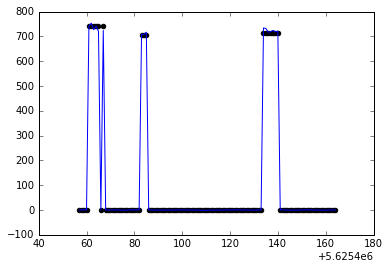

In [146]:
plt.scatter(g_ftest.index, g_ptest, color='black')
plt.plot(g_ftest.index, goog_rsi9_pred, color='blue', linewidth=1)

In [147]:
original9_goog = rsi_9_model.predict(g_features)

In [148]:
rsi_9_model.score(g_features, g_prices)

0.99340739986516846

In [149]:
np.sum((original9_goog - g_prices) ** 2)

Sell Signal Price    158046.111838
dtype: float64

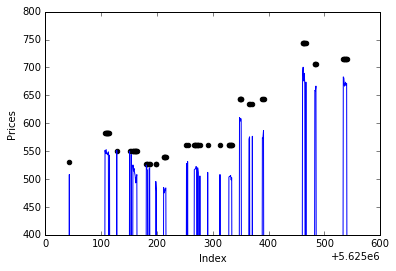

In [150]:
plt.scatter(g_features.index, g_prices, color='black')
plt.ylim(400)
plt.ylabel('Prices')
plt.xlabel('Index')
plt.plot(g_features.index, original9_goog, color='blue', linewidth=1)

Some fairly decent results, but let's try a company in a completely different industry, but one wit a shorter history than Apple.  Zumiez is a good candidate.

In [151]:
zumz = tick_gettr('ZUMZ')

In [157]:
zumz_rsi = rsi(zumz, 9)

In [158]:
zumz['RSI'] = zumz_rsi

/Users/amagi/anaconda/envs/mlnd/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [160]:
zumz = zumz.iloc[9:]

In [162]:
zumz.shape

(2767, 8)

In [164]:
zumz['Sell Price'] = pd.Series(0, np.arange(2767))
zumz.ix[zumz.RSI > 70, 'Sell Price'] = zumz['Adj-C']

In [165]:
zumz['Buy Price'] = pd.Series(0, np.arange(2767))
zumz.ix[zumz.RSI < 30, 'Buy Price'] = zumz['Adj-C']

In [166]:
zumz['Sell Signal Price'] = pd.Series(0, np.arange(2767))

In [167]:
zumz.head(2)

,Ticker,Date,Adj-O,Adj-H,Adj-L,Adj-C,Adj-Vol,RSI,Sell Price,Buy Price,Sell Signal Price
14147326,ZUMZ,2005-05-19,12.97,12.970,12.500,12.85,93600.0,58.96,NaN,NaN,NaN
14147327,ZUMZ,2005-05-20,13.00,13.225,12.565,12.75,230800.0,61.07,NaN,NaN,NaN


In [168]:
zumz_q = zumz[['Adj-C', 'RSI', 'Sell Price', 'Buy Price', 'Sell Signal Price']]

In [179]:
zumz_q = zumz_q.fillna(0)

for price in zumz_q.iterrows():
    if 0 < price[1][1] < 30:
        place = zumz_q.query(price[0])
        p_start = zumz_q.index.get_loc(place.name)
        temp_list = zumz_q[p_start:]
        
        for i in temp_list.iterrows():
            if i[1][1] > 70:
                price[1][4] = i[1][0]
                break

In [180]:
zumz_q.head(2)

,Adj-C,RSI,Sell Price,Buy Price,Sell Signal Price
14147326,12.85,58.96,0.0,0.0,0.0
14147327,12.75,61.07,0.0,0.0,0.0


In [181]:
z_features = zumz_q[['RSI', 'Buy Price']]
z_prices = zumz_q[['Sell Signal Price']]

z_ftrain = z_features[:2213]
z_ptrain = z_prices[:2213]
z_ftest = z_features[2213:]
z_ptest = z_prices[2213:]

In [182]:
zumz_rsi9 = rsi_9_model.predict(z_features)

In [183]:
rsi_9_model.score(z_features, z_prices)

0.9696304006226093

In [184]:
np.sum((zumz_rsi9 - z_prices) ** 2)

Sell Signal Price    6900.905603
dtype: float64

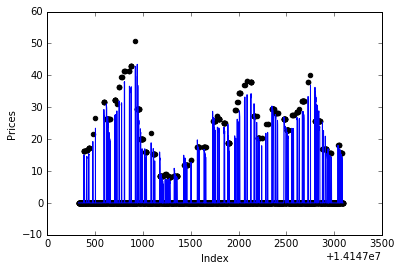

In [185]:
plt.scatter(z_features.index, z_prices, color='black')
plt.ylabel('Prices')
plt.xlabel('Index')
plt.plot(z_features.index, zumz_rsi9, color='blue', linewidth=1)

Again, the back of the envelope calculation.

In [186]:
zumz_9_list = []

for line in zumz_q.iterrows():
    if line[1][4] > 0:
        asd = line[1][4] - line[1][3]
        zumz_9_list.append(asd)
        
sum(zumz_9_list)

104.58000000000001

In [187]:
len(zumz_9_list)

455